# Prepare the libraries

In [79]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData

try: # If running on Jupyter
    air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
except FileNotFoundError: # If running on colab
    air_passengers_df = pd.read_csv("air_passengers.csv")

# Note: If the column holding the time values is not called time, you will want to specify the name of this column.
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

First we are going to do simple forecasting and save the values. Later we are going to do ensemble forecasting.
We see that the median used to get ensemble_mean are the python function, so we proof its behavior.

In [80]:
import statistics
print(statistics.median([1, 3, 5, 7, 9, 11, 13]))

print(statistics.median([1, 3, 5, 9, 11, 13]))  # Te hace la media de los dos de enmedio
print(statistics.median([0, 1, 4, 9, 11, 13])) 

7
7.0
6.5


How to get a covariance?

In [81]:
import numpy as np
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]

np.cov(x,y)[0,1]
np.cov(x,y)

array([[11.71      , -4.286     ],
       [-4.286     ,  2.14413333]])

# The first version of Bates & Granger, it works?

In [82]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    linear_model,
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
# here we include 5 different models
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("Theta", theta.ThetaParams(m=12)),                
            ]
        )

# Forecast with median ensemble vs Bates & Granger ensemble

## Median ensemble

In [83]:
# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParamM = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
mM= KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParamM
    )

# fit and predict
mM.fit()

# predict for the next 30 steps
fcstM = mM.predict(steps=30)

# aggregate individual model results
mM.aggregate()

# plot to visualize
mM.plot()

## Bates & Granger ensemble

<AxesSubplot: xlabel='time', ylabel='y'>

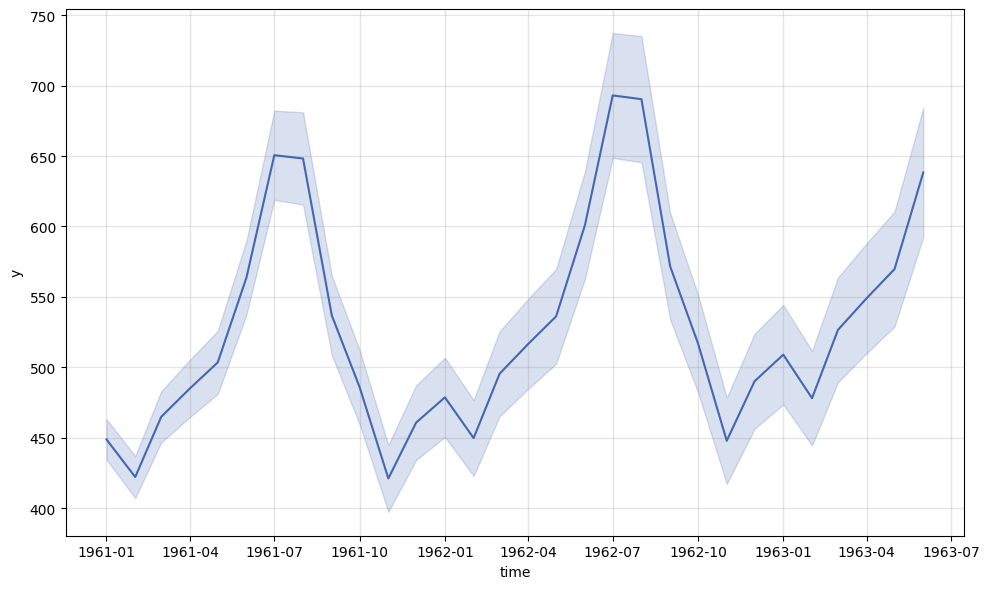

In [ ]:
# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParamBG = {
    "models": model_params,
    "aggregation": "bates&gates",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
mBG = KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParamBG
    )

# fit and predict
mBG.fit()

# predict for the next 30 steps
fcstBG = mBG.predict(steps=30)

# aggregate individual model results
mBG.aggregate()

# plot to visualize
mBG.plot()

## Comparation

In [ ]:
# print(fcstM.fcst_df)
# print(fcstBG.fcst_df)

pred_dt = pd.concat([fcstM.fcst_df, fcstBG.fcst_df], axis=1)
pred_dt

,time,fcst,fcst_lower,fcst_upper,time,fcst,fcst_lower,fcst_upper
0,1961-01-01,449.434914,437.024206,460.652257,1961-01-01,448.766770,434.425770,463.107771
1,1961-02-01,420.860581,406.405477,432.982577,1961-02-01,422.079333,407.169015,436.989652
2,1961-03-01,467.345820,450.029985,481.888143,1961-03-01,464.800899,446.635022,482.966776
3,1961-04-01,488.708000,469.131123,507.235814,1961-04-01,485.012278,464.701424,505.323133
4,1961-05-01,503.636400,479.043701,528.229100,1961-05-01,503.455406,481.071669,525.839142
5,1961-06-01,566.379543,536.335276,596.252611,1961-06-01,563.783862,537.445943,590.121781
6,1961-07-01,658.079209,620.746401,695.412017,1961-07-01,650.632532,618.980424,682.284640
7,1961-08-01,653.261685,613.848508,692.674862,1961-08-01,648.293452,615.506649,681.080255
8,1961-09-01,534.889855,500.927017,568.852692,1961-09-01,536.876690,508.658445,565.094936
9,1961-10-01,491.098703,460.703462,514.371474,1961-10-01,485.940138,459.535404,512.344873


In [ ]:
import statsmodels.api as sm

_X = list(range(10))
X = sm.add_constant(_X)

print(X)
print(_X)

[[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]
 [1. 6.]
 [1. 7.]
 [1. 8.]
 [1. 9.]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
import numpy as np
_X_quad = np.column_stack([_X, np.power(_X, 2)])
X_quad = sm.add_constant(_X_quad)

print(X_quad)

[[ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]
 [ 1.  6. 36.]
 [ 1.  7. 49.]
 [ 1.  8. 64.]
 [ 1.  9. 81.]]


In [ ]:
from kats.models.ensemble.weighted_avg_ensemble import WeightedAvgEnsemble

m = WeightedAvgEnsemble(data = air_passengers_ts, 
                        params = model_params)

m.fit()

p = m.predict(steps=30)

<AxesSubplot: xlabel='time', ylabel='y'>

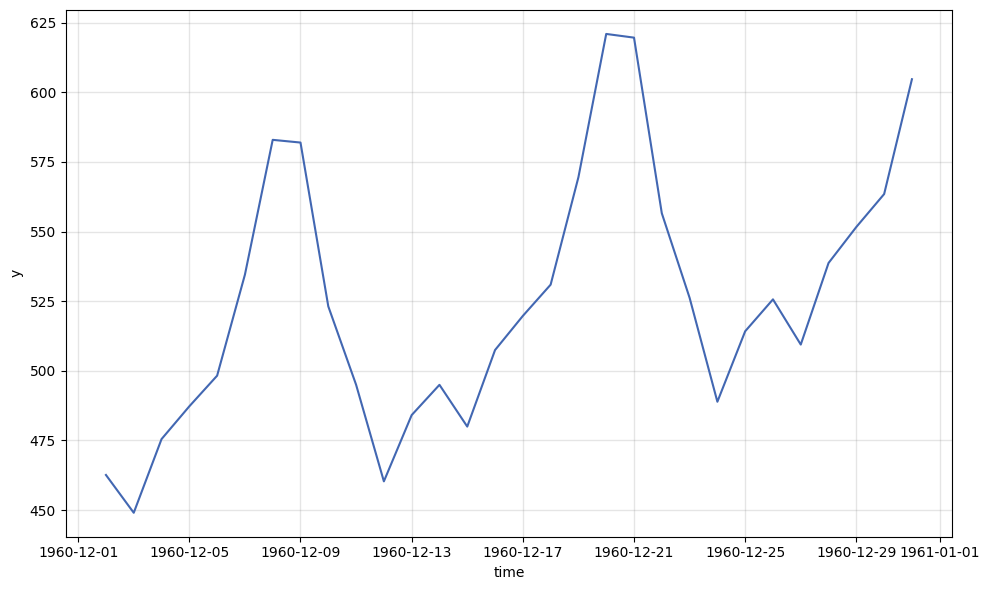

In [ ]:
m.plot()

In [ ]:
pred_dt = pd.concat([pred_dt, p], axis=1)
pred_dt

,time,fcst,fcst_lower,fcst_upper,time,fcst,fcst_lower,fcst_upper,time,fcst
0,1961-01-01,449.434914,437.024206,460.652257,1961-01-01,448.766770,434.425770,463.107771,1960-12-02,462.581308
1,1961-02-01,420.860581,406.405477,432.982577,1961-02-01,422.079333,407.169015,436.989652,1960-12-03,449.002585
2,1961-03-01,467.345820,450.029985,481.888143,1961-03-01,464.800899,446.635022,482.966776,1960-12-04,475.458581
3,1961-04-01,488.708000,469.131123,507.235814,1961-04-01,485.012278,464.701424,505.323133,1960-12-05,487.234784
4,1961-05-01,503.636400,479.043701,528.229100,1961-05-01,503.455406,481.071669,525.839142,1960-12-06,498.234664
5,1961-06-01,566.379543,536.335276,596.252611,1961-06-01,563.783862,537.445943,590.121781,1960-12-07,534.502454
6,1961-07-01,658.079209,620.746401,695.412017,1961-07-01,650.632532,618.980424,682.284640,1960-12-08,582.917332
7,1961-08-01,653.261685,613.848508,692.674862,1961-08-01,648.293452,615.506649,681.080255,1960-12-09,581.943289
8,1961-09-01,534.889855,500.927017,568.852692,1961-09-01,536.876690,508.658445,565.094936,1960-12-10,523.125272
9,1961-10-01,491.098703,460.703462,514.371474,1961-10-01,485.940138,459.535404,512.344873,1960-12-11,494.990743


In [ ]:
from kats.models.ensemble.bates_granger_ensemble_copy import BatesGrangerEnsemble

m = BatesGrangerEnsemble(data = air_passengers_ts, 
                        params = model_params)

m.fit()

p = m.predict(steps=30)

TypeError: __init__() missing 1 required positional argument: 'back_method'

In [ ]:
p

,time,fcst
0,1960-12-02,457.058318
1,1960-12-03,434.669448
2,1960-12-04,470.856155
3,1960-12-05,486.493061
4,1960-12-06,501.108395
5,1960-12-07,551.789187
6,1960-12-08,621.635186
7,1960-12-09,618.913247
8,1960-12-10,529.291436
9,1960-12-11,486.793761


In [ ]:
pred_dt = pd.concat([pred_dt, p], axis=1)
pred_dt

,time,fcst,fcst_lower,fcst_upper,time,fcst,fcst_lower,fcst_upper,time,fcst,time,fcst
0,1961-01-01,449.434914,437.024206,460.652257,1961-01-01,448.766770,434.425770,463.107771,1960-12-02,462.581308,1960-12-02,457.058318
1,1961-02-01,420.860581,406.405477,432.982577,1961-02-01,422.079333,407.169015,436.989652,1960-12-03,449.002585,1960-12-03,434.669448
2,1961-03-01,467.345820,450.029985,481.888143,1961-03-01,464.800899,446.635022,482.966776,1960-12-04,475.458581,1960-12-04,470.856155
3,1961-04-01,488.708000,469.131123,507.235814,1961-04-01,485.012278,464.701424,505.323133,1960-12-05,487.234784,1960-12-05,486.493061
4,1961-05-01,503.636400,479.043701,528.229100,1961-05-01,503.455406,481.071669,525.839142,1960-12-06,498.234664,1960-12-06,501.108395
5,1961-06-01,566.379543,536.335276,596.252611,1961-06-01,563.783862,537.445943,590.121781,1960-12-07,534.502454,1960-12-07,551.789187
6,1961-07-01,658.079209,620.746401,695.412017,1961-07-01,650.632532,618.980424,682.284640,1960-12-08,582.917332,1960-12-08,621.635186
7,1961-08-01,653.261685,613.848508,692.674862,1961-08-01,648.293452,615.506649,681.080255,1960-12-09,581.943289,1960-12-09,618.913247
8,1961-09-01,534.889855,500.927017,568.852692,1961-09-01,536.876690,508.658445,565.094936,1960-12-10,523.125272,1960-12-10,529.291436
9,1961-10-01,491.098703,460.703462,514.371474,1961-10-01,485.940138,459.535404,512.344873,1960-12-11,494.990743,1960-12-11,486.793761
